In [ ]:
! pip install opendatasets

In [ ]:
#=======================================
# Step-1: Import Libraries
#=======================================

import warnings
warnings.filterwarnings('ignore')

import os
from glob import glob
import opendatasets as od

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from tensorflow.keras.metrics import Precision,Recall

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


In [ ]:
#======================================
# Step-2: Load Dataset
#======================================
od.download('https://www.kaggle.com/datasets/orvile/pmram-bangladeshi-brain-cancer-mri-dataset')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chanchalsaha7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/orvile/pmram-bangladeshi-brain-cancer-mri-dataset


100%|██████████| 161M/161M [00:00<00:00, 1.41GB/s]

In [ ]:
# {"username":"chanchalsaha7","key":"9ae140efdb070deb48f1b8effc11f3d5"}

In [ ]:
#==========================================================
# Step-3: Create Data frame using each file path & label
#==========================================================
base_dir='/content/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Augmented Data'
pattern=os.path.join(base_dir,'**','*.jpg')

filepaths=glob(pattern,recursive=True)

df=pd.DataFrame({
    'path':filepaths,
    'label':[os.path.basename(os.path.dirname(f)) for f in filepaths]
})

df


,path,label
0,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Pituitary
1,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Pituitary
2,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Pituitary
3,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Pituitary
4,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Pituitary
...,...,...
5999,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Meningioma
6000,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Meningioma
6001,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Meningioma
6002,/content/pmram-bangladeshi-brain-cancer-mri-da...,512Meningioma


In [ ]:
#unique label
df['label'].unique()

array(['512Pituitary', '512Normal', '512Glioma', '512Meningioma'],
      dtype=object)

In [ ]:
# label cleaning

df['label']=df['label'].map({
    '512Glioma':'Glioma',
    '512Meningioma':'Meningioma',
    '512Pituitary':'Pituitary',
    '512Normal':'Normal'
})

In [ ]:
# check update label
df['label'].unique()

array(['Pituitary', 'Normal', 'Glioma', 'Meningioma'], dtype=object)

In [ ]:
#======================================
# Image preprocessing( Augmentation)
#======================================

train_gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest'
)

val_gen=ImageDataGenerator(rescale=1./255)

In [ ]:
#========================================
# Model build up function
#========================================

def build_model():

    base_model=ResNet50(weights='imagenet',include_top=False,input_shape=IMG_SIZE+(3,),name='vgg19')
    base_model.trainable=False
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.2)(x)
    x=BatchNormalization()(x)
    outputs=Dense(4,activation='softmax')(x)

    model=Model(base_model.input,outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy',Precision(),Recall()]
    )
    return model,base_model

In [ ]:
#=====================================
# Step-4: K fold split
#=====================================

x=df['path'].values
y=df['label'].values

kf=KFold(n_splits=5,shuffle=True,random_state=42)

fold_no=1
results=[]

for train_idx,val_idx in kf.split(x):
    train_df=df.iloc[train_idx]
    val_df=df.iloc[val_idx]



    BATCH_SIZE=32
    SEED=42
    IMG_SIZE=(224,224)

    train_image=train_gen.flow_from_dataframe(
        train_df,
        x_col='path',
        y_col='label',
        target_size=IMG_SIZE,
        shuffle=True,
        batch_size=BATCH_SIZE,
        seed=SEED,
        class_mode='categorical'
    )

    val_image=val_gen.flow_from_dataframe(
        val_df,
        x_col='path',
        y_col='label',
        target_size=IMG_SIZE,
        shuffle=False,
        batch_size=BATCH_SIZE,
        seed=SEED,
        class_mode='categorical'
    )

    model,base_model=build_model()
    print('Fold-no: ', fold_no)

    er=EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    lr=ReduceLROnPlateau(
        monitor='val_loss',
        patience=2,
        factor=0.2,
        min_lr=1e-7,
        verbose=1
    )
    ck=ModelCheckpoint(
        f'best_model{fold_no}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1

    )


    model.fit(
        train_image,
        validation_data=val_image,
        epochs=10,
        callbacks=[ck,er,lr],
        verbose=1
    )

    base_model.trainable=True

    for layer in model.layers[:-30]:
        layer.trainable=False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy',Precision(),Recall()]

    )
    model.fit(
        train_image,
        validation_data=val_image,
        epochs=10,
        callbacks=[ck,lr,er],
        verbose=1
    )

    results.append(model.evaluate(val_image))
    fold_no+=1

print('\n final k-fold Results: ',results)




Found 4803 validated image filenames belonging to 4 classes.
Found 1201 validated image filenames belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Fold-no:  1
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.4115 - loss: 1.3304 - precision: 0.4793 - recall: 0.2629
Epoch 1: val_accuracy improved from -inf to 0.44213, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 97s 537ms/step - accuracy: 0.4115 - loss: 1.3300 - precision: 0.4795 - recall: 0.2628 - val_accuracy: 0.4421 - val_loss: 1.2921 - val_precision: 0.8438 - val_recall: 0.0899 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.4367 - loss: 1.1853 - precision: 0.6556 - recall: 0.1608
Epoch 2: val_accuracy did not improve from 0.44213
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 443ms/step - accuracy: 0.4367 - loss: 1.1853 - precision: 0.6558 - recall: 0.1607 - val_accuracy: 0.2448 - val_loss: 1.3882 - val_precision: 0.4023 - val_recall: 0.2073 - learning_rate: 0.0010
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.4506 - loss: 1.1784 - precision: 0.7299 - recall: 0.1233
Epoch 3: val_accuracy did not improve from 0.44213
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 437ms/step - accuracy: 0.4506 - loss: 1.1783 - precision: 0.7300 - recall: 0.1233 - val_accuracy: 0.3938 - val_loss: 1.2357 - val_precision: 0.6107 - val_recall: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 444ms/step - accuracy: 0.4511 - loss: 1.1782 - precision: 0.7473 - recall: 0.1182 - val_accuracy: 0.4688 - val_loss: 1.1548 - val_precision: 0.7885 - val_recall: 0.1490 - learning_rate: 0.0010
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.4529 - loss: 1.1770 - precision: 0.7156 - recall: 0.1157
Epoch 6: val_accuracy improved from 0.46878 to 0.51041, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 459ms/step - accuracy: 0.4530 - loss: 1.1769 - precision: 0.7158 - recall: 0.1158 - val_accuracy: 0.5104 - val_loss: 1.1109 - val_precision: 0.7778 - val_recall: 0.1632 - learning_rate: 0.0010
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.4612 - loss: 1.1562 - precision: 0.7113 - recall: 0.1376
Epoch 7: val_accuracy did not improve from 0.51041
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 442ms/step - accuracy: 0.4612 - loss: 1.1562 - precision: 0.7114 - recall: 0.1376 - val_accuracy: 0.4155 - val_loss: 1.1750 - val_precision: 0.7649 - val_recall: 0.1707 - learning_rate: 0.0010
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.4406 - loss: 1.1755 - precision: 0.7022 - recall: 0.1251
Epoch 8: val_accuracy did not improve from 0.51041
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 444ms/step - accuracy: 0.4407 - loss: 1.1754 - precision: 0.7024 - recall: 0.1251 - val_accuracy: 0.4863 - val_loss: 1.1096 - val_precision: 0.8462 - val_recall: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 454ms/step - accuracy: 0.5548 - loss: 1.0306 - precision_1: 0.6814 - recall_1: 0.3287 - val_accuracy: 0.5254 - val_loss: 1.1217 - val_precision_1: 0.5748 - val_recall_1: 0.4513 - learning_rate: 1.0000e-04
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.5782 - loss: 0.9877 - precision_1: 0.6784 - recall_1: 0.4265
Epoch 3: val_accuracy improved from 0.52540 to 0.52623, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 458ms/step - accuracy: 0.5782 - loss: 0.9877 - precision_1: 0.6785 - recall_1: 0.4264 - val_accuracy: 0.5262 - val_loss: 1.0750 - val_precision_1: 0.6448 - val_recall_1: 0.3855 - learning_rate: 1.0000e-04
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.5710 - loss: 0.9756 - precision_1: 0.6906 - recall_1: 0.3843
Epoch 4: val_accuracy improved from 0.52623 to 0.60866, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 453ms/step - accuracy: 0.5711 - loss: 0.9754 - precision_1: 0.6906 - recall_1: 0.3845 - val_accuracy: 0.6087 - val_loss: 0.9305 - val_precision_1: 0.6489 - val_recall_1: 0.5262 - learning_rate: 1.0000e-04
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.6206 - loss: 0.8912 - precision_1: 0.7175 - recall_1: 0.4866
Epoch 5: val_accuracy improved from 0.60866 to 0.63197, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 459ms/step - accuracy: 0.6206 - loss: 0.8913 - precision_1: 0.7175 - recall_1: 0.4867 - val_accuracy: 0.6320 - val_loss: 0.8717 - val_precision_1: 0.7186 - val_recall_1: 0.5337 - learning_rate: 1.0000e-04
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.6328 - loss: 0.8706 - precision_1: 0.7132 - recall_1: 0.5013
Epoch 6: val_accuracy improved from 0.63197 to 0.65279, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 456ms/step - accuracy: 0.6328 - loss: 0.8706 - precision_1: 0.7132 - recall_1: 0.5014 - val_accuracy: 0.6528 - val_loss: 0.8117 - val_precision_1: 0.7253 - val_recall_1: 0.5737 - learning_rate: 1.0000e-04
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.6389 - loss: 0.8523 - precision_1: 0.7225 - recall_1: 0.5167
Epoch 7: val_accuracy did not improve from 0.65279
151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 450ms/step - accuracy: 0.6389 - loss: 0.8523 - precision_1: 0.7224 - recall_1: 0.5167 - val_accuracy: 0.5987 - val_loss: 0.9243 - val_precision_1: 0.6645 - val_recall_1: 0.5129 - learning_rate: 1.0000e-04
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.6523 - loss: 0.8347 - precision_1: 0.7197 - recall_1: 0.5446
Epoch 8: val_accuracy improved from 0.65279 to 0.65362, saving model to best_model1.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 451ms/step - accuracy: 0.6523 - loss: 0.8347 - precision_1: 0.7197 - recall_1: 0.5446 - val_accuracy: 0.6536 - val_loss: 0.8474 - val_precision_1: 0.7102 - val_recall_1: 0.5978 - learning_rate: 1.0000e-04
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6635 - loss: 0.8005 - precision_1: 0.7462 - recall_1: 0.5572
Epoch 9: val_accuracy improved from 0.65362 to 0.72856, saving model to best_model1.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 455ms/step - accuracy: 0.6636 - loss: 0.8003 - precision_1: 0.7462 - recall_1: 0.5573 - val_accuracy: 0.7286 - val_loss: 0.6533 - val_precision_1: 0.7672 - val_recall_1: 0.6586 - learning_rate: 2.0000e-05
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.6830 - loss: 0.7490 - precision_1: 0.7451 - recall_1: 0.5926
Epoch 10: val_accuracy did not improve from 0.72856
151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 455ms/step - accuracy: 0.6830 - loss: 0.7490 - precision_1: 0.7451 - recall_1: 0.5926 - val_accuracy: 0.7119 - val_loss: 0.6524 - val_precision_1: 0.7717 - val_recall_1: 0.6586 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 10.
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.7705 - loss: 0.5559 - precision_1: 0.8225 - recall_1: 0.7211
Found 4803 validated image filenames belonging to 4 classes.
Found 1201 validated image filenames belonging to 4 classes.
Fold-no:  2
Epoch 1/10
151/151 ━━━━━━━━━━━━━━

151/151 ━━━━━━━━━━━━━━━━━━━━ 91s 521ms/step - accuracy: 0.3871 - loss: 1.3675 - precision_2: 0.4536 - recall_2: 0.2415 - val_accuracy: 0.5712 - val_loss: 1.1433 - val_precision_2: 0.8926 - val_recall_2: 0.1107 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.4476 - loss: 1.1733 - precision_2: 0.6801 - recall_2: 0.1613
Epoch 2: val_accuracy did not improve from 0.57119
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 441ms/step - accuracy: 0.4476 - loss: 1.1733 - precision_2: 0.6802 - recall_2: 0.1612 - val_accuracy: 0.2506 - val_loss: 1.4553 - val_precision_2: 0.3226 - val_recall_2: 0.2256 - learning_rate: 0.0010
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.4605 - loss: 1.1662 - precision_2: 0.7544 - recall_2: 0.1413
Epoch 3: val_accuracy did not improve from 0.57119

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 440ms/step - accuracy: 0.4604 - loss: 1.1662 - precision_2: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 446ms/step - accuracy: 0.5307 - loss: 1.0451 - precision_3: 0.6520 - recall_3: 0.3518 - val_accuracy: 0.5962 - val_loss: 1.0161 - val_precision_3: 0.6878 - val_recall_3: 0.4238 - learning_rate: 1.0000e-04
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.5973 - loss: 0.9652 - precision_3: 0.6873 - recall_3: 0.4481
Epoch 3: val_accuracy did not improve from 0.59617
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 447ms/step - accuracy: 0.5973 - loss: 0.9652 - precision_3: 0.6873 - recall_3: 0.4481 - val_accuracy: 0.5812 - val_loss: 0.9987 - val_precision_3: 0.6359 - val_recall_3: 0.5162 - learning_rate: 1.0000e-04
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.5851 - loss: 0.9488 - precision_3: 0.6692 - recall_3: 0.4380
Epoch 4: val_accuracy did not improve from 0.59617
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 438ms/step - accuracy: 0.5852 - loss: 0.9487 - precision_3: 0.6693 - recall_3: 0.4382 - val_accuracy: 0.4654 - val_loss: 1.2179 - v

151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 452ms/step - accuracy: 0.6428 - loss: 0.8346 - precision_3: 0.7311 - recall_3: 0.5130 - val_accuracy: 0.6886 - val_loss: 0.7353 - val_precision_3: 0.7626 - val_recall_3: 0.5937 - learning_rate: 2.0000e-05
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.6624 - loss: 0.8094 - precision_3: 0.7269 - recall_3: 0.5559
Epoch 7: val_accuracy improved from 0.68859 to 0.69442, saving model to best_model2.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 446ms/step - accuracy: 0.6624 - loss: 0.8094 - precision_3: 0.7269 - recall_3: 0.5560 - val_accuracy: 0.6944 - val_loss: 0.7110 - val_precision_3: 0.7607 - val_recall_3: 0.5928 - learning_rate: 2.0000e-05
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.6697 - loss: 0.7771 - precision_3: 0.7399 - recall_3: 0.5852
Epoch 8: val_accuracy improved from 0.69442 to 0.70525, saving model to best_model2.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 453ms/step - accuracy: 0.6697 - loss: 0.7771 - precision_3: 0.7399 - recall_3: 0.5851 - val_accuracy: 0.7052 - val_loss: 0.6938 - val_precision_3: 0.7582 - val_recall_3: 0.6137 - learning_rate: 2.0000e-05
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.6855 - loss: 0.7690 - precision_3: 0.7490 - recall_3: 0.6041
Epoch 9: val_accuracy did not improve from 0.70525
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 443ms/step - accuracy: 0.6855 - loss: 0.7689 - precision_3: 0.7490 - recall_3: 0.6040 - val_accuracy: 0.6711 - val_loss: 0.7549 - val_precision_3: 0.7055 - val_recall_3: 0.6103 - learning_rate: 2.0000e-05
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.6833 - loss: 0.7662 - precision_3: 0.7505 - recall_3: 0.6003
Epoch 10: val_accuracy improved from 0.70525 to 0.70774, saving model to best_model2.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 454ms/step - accuracy: 0.6833 - loss: 0.7662 - precision_3: 0.7505 - recall_3: 0.6003 - val_accuracy: 0.7077 - val_loss: 0.6809 - val_precision_3: 0.7627 - val_recall_3: 0.6503 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 10.
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.8439 - loss: 0.4207 - precision_3: 0.8842 - recall_3: 0.8103
Found 4803 validated image filenames belonging to 4 classes.
Found 1201 validated image filenames belonging to 4 classes.
Fold-no:  3
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.3998 - loss: 1.3513 - precision_4: 0.4874 - recall_4: 0.2391
Epoch 1: val_accuracy improved from -inf to 0.47877, saving model to best_model3.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 89s 515ms/step - accuracy: 0.3999 - loss: 1.3508 - precision_4: 0.4878 - recall_4: 0.2390 - val_accuracy: 0.4788 - val_loss: 1.2081 - val_precision_4: 0.8435 - val_recall_4: 0.1032 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.4327 - loss: 1.1857 - precision_4: 0.6673 - recall_4: 0.1571
Epoch 2: val_accuracy did not improve from 0.47877
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 436ms/step - accuracy: 0.4327 - loss: 1.1857 - precision_4: 0.6675 - recall_4: 0.1570 - val_accuracy: 0.2606 - val_loss: 1.4100 - val_precision_4: 0.3701 - val_recall_4: 0.2290 - learning_rate: 0.0010
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.4573 - loss: 1.1587 - precision_4: 0.7664 - recall_4: 0.1349
Epoch 3: val_accuracy did not improve from 0.47877

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 439ms/step - accuracy: 0.4572 - loss: 1.1589 - precision_4: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 441ms/step - accuracy: 0.4713 - loss: 1.1360 - precision_4: 0.7546 - recall_4: 0.1521 - val_accuracy: 0.5112 - val_loss: 1.0898 - val_precision_4: 0.8074 - val_recall_4: 0.1640 - learning_rate: 2.0000e-04
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.4794 - loss: 1.1272 - precision_4: 0.7179 - recall_4: 0.1652
Epoch 6: val_accuracy did not improve from 0.51124
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 435ms/step - accuracy: 0.4794 - loss: 1.1272 - precision_4: 0.7180 - recall_4: 0.1652 - val_accuracy: 0.4221 - val_loss: 1.1382 - val_precision_4: 0.6432 - val_recall_4: 0.2057 - learning_rate: 2.0000e-04
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.4950 - loss: 1.1173 - precision_4: 0.7421 - recall_4: 0.1661
Epoch 7: val_accuracy improved from 0.51124 to 0.51374, saving model to best_model3.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 438ms/step - accuracy: 0.4950 - loss: 1.1172 - precision_4: 0.7421 - recall_4: 0.1661 - val_accuracy: 0.5137 - val_loss: 1.0628 - val_precision_4: 0.7695 - val_recall_4: 0.1890 - learning_rate: 2.0000e-04
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.4992 - loss: 1.1072 - precision_4: 0.7707 - recall_4: 0.1636
Epoch 8: val_accuracy improved from 0.51374 to 0.56453, saving model to best_model3.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 442ms/step - accuracy: 0.4992 - loss: 1.1072 - precision_4: 0.7706 - recall_4: 0.1636 - val_accuracy: 0.5645 - val_loss: 1.0376 - val_precision_4: 0.7821 - val_recall_4: 0.1823 - learning_rate: 2.0000e-04
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.5071 - loss: 1.1067 - precision_4: 0.7493 - recall_4: 0.1602
Epoch 9: val_accuracy did not improve from 0.56453
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 446ms/step - accuracy: 0.5071 - loss: 1.1067 - precision_4: 0.7494 - recall_4: 0.1602 - val_accuracy: 0.5645 - val_loss: 1.0284 - val_precision_4: 0.7703 - val_recall_4: 0.1898 - learning_rate: 2.0000e-04
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.5069 - loss: 1.0924 - precision_4: 0.7828 - recall_4: 0.1757
Epoch 10: val_accuracy did not improve from 0.56453
151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 448ms/step - accuracy: 0.5069 - loss: 1.0924 - precision_4: 0.7826 - recall_4: 0.1757 - val_accuracy: 0.4679 - val_loss: 1.1184 -

151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 449ms/step - accuracy: 0.6325 - loss: 0.8736 - precision_5: 0.7144 - recall_5: 0.4852 - val_accuracy: 0.6528 - val_loss: 0.8254 - val_precision_5: 0.7563 - val_recall_5: 0.5246 - learning_rate: 2.0000e-05
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.6537 - loss: 0.8319 - precision_5: 0.7475 - recall_5: 0.5398
Epoch 5: val_accuracy did not improve from 0.65279
151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 448ms/step - accuracy: 0.6537 - loss: 0.8320 - precision_5: 0.7474 - recall_5: 0.5397 - val_accuracy: 0.6278 - val_loss: 0.8600 - val_precision_5: 0.7213 - val_recall_5: 0.5279 - learning_rate: 2.0000e-05
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.6694 - loss: 0.8119 - precision_5: 0.7470 - recall_5: 0.5500
Epoch 6: val_accuracy improved from 0.65279 to 0.68526, saving model to best_model3.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 447ms/step - accuracy: 0.6693 - loss: 0.8120 - precision_5: 0.7469 - recall_5: 0.5500 - val_accuracy: 0.6853 - val_loss: 0.7664 - val_precision_5: 0.7416 - val_recall_5: 0.6070 - learning_rate: 2.0000e-05
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.6616 - loss: 0.7990 - precision_5: 0.7310 - recall_5: 0.5599
Epoch 7: val_accuracy improved from 0.68526 to 0.68859, saving model to best_model3.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 445ms/step - accuracy: 0.6617 - loss: 0.7991 - precision_5: 0.7310 - recall_5: 0.5599 - val_accuracy: 0.6886 - val_loss: 0.7415 - val_precision_5: 0.7549 - val_recall_5: 0.6153 - learning_rate: 2.0000e-05
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.6788 - loss: 0.7807 - precision_5: 0.7440 - recall_5: 0.5807
Epoch 8: val_accuracy did not improve from 0.68859
151/151 ━━━━━━━━━━━━━━━━━━━━ 65s 431ms/step - accuracy: 0.6788 - loss: 0.7807 - precision_5: 0.7440 - recall_5: 0.5808 - val_accuracy: 0.6661 - val_loss: 0.8018 - val_precision_5: 0.7234 - val_recall_5: 0.6120 - learning_rate: 2.0000e-05
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.6801 - loss: 0.7612 - precision_5: 0.7539 - recall_5: 0.5896
Epoch 9: val_accuracy did not improve from 0.68859

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
151/151 ━━━━━━━━━━━━━━━━━━━━ 65s 433ms/step - accuracy: 0.6800 - loss: 0.7613 - precisi

151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 436ms/step - accuracy: 0.6988 - loss: 0.7571 - precision_5: 0.7707 - recall_5: 0.5929 - val_accuracy: 0.6961 - val_loss: 0.7542 - val_precision_5: 0.7429 - val_recall_5: 0.6353 - learning_rate: 4.0000e-06
Restoring model weights from the end of the best epoch: 7.
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7753 - loss: 0.5929 - precision_5: 0.8582 - recall_5: 0.7225
Found 4803 validated image filenames belonging to 4 classes.
Found 1201 validated image filenames belonging to 4 classes.
Fold-no:  4
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.3934 - loss: 1.3608 - precision_6: 0.4570 - recall_6: 0.2273
Epoch 1: val_accuracy improved from -inf to 0.41965, saving model to best_model4.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 87s 499ms/step - accuracy: 0.3936 - loss: 1.3602 - precision_6: 0.4574 - recall_6: 0.2273 - val_accuracy: 0.4197 - val_loss: 1.2282 - val_precision_6: 0.8355 - val_recall_6: 0.1057 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.4401 - loss: 1.1827 - precision_6: 0.7103 - recall_6: 0.1587
Epoch 2: val_accuracy did not improve from 0.41965
151/151 ━━━━━━━━━━━━━━━━━━━━ 65s 433ms/step - accuracy: 0.4402 - loss: 1.1827 - precision_6: 0.7104 - recall_6: 0.1586 - val_accuracy: 0.3447 - val_loss: 1.3939 - val_precision_6: 0.5882 - val_recall_6: 0.1665 - learning_rate: 0.0010
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.4506 - loss: 1.1704 - precision_6: 0.7743 - recall_6: 0.1285
Epoch 3: val_accuracy did not improve from 0.41965
151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 447ms/step - accuracy: 0.4506 - loss: 1.1703 - precision_6: 0.7743 - recall_6: 0.1286 - val_accuracy: 0.4188 - val_loss: 1.1790 - val_preci

151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 437ms/step - accuracy: 0.4268 - loss: 1.1853 - precision_6: 0.7449 - recall_6: 0.1109 - val_accuracy: 0.4821 - val_loss: 1.1408 - val_precision_6: 0.7178 - val_recall_6: 0.1440 - learning_rate: 0.0010
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.4716 - loss: 1.1464 - precision_6: 0.7799 - recall_6: 0.1380
Epoch 5: val_accuracy did not improve from 0.48210
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 439ms/step - accuracy: 0.4715 - loss: 1.1465 - precision_6: 0.7798 - recall_6: 0.1380 - val_accuracy: 0.4013 - val_loss: 1.1720 - val_precision_6: 0.7231 - val_recall_6: 0.1457 - learning_rate: 0.0010
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.4471 - loss: 1.1645 - precision_6: 0.7992 - recall_6: 0.1353
Epoch 6: val_accuracy did not improve from 0.48210
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 439ms/step - accuracy: 0.4471 - loss: 1.1646 - precision_6: 0.7989 - recall_6: 0.1353 - val_accuracy: 0.4588 - val_loss: 1.1105 - val_preci

151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 443ms/step - accuracy: 0.4675 - loss: 1.1381 - precision_6: 0.7310 - recall_6: 0.1605 - val_accuracy: 0.4854 - val_loss: 1.0928 - val_precision_6: 0.7419 - val_recall_6: 0.1724 - learning_rate: 2.0000e-04
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.4760 - loss: 1.1343 - precision_6: 0.6952 - recall_6: 0.1636
Epoch 10: val_accuracy did not improve from 0.48543
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 436ms/step - accuracy: 0.4760 - loss: 1.1343 - precision_6: 0.6953 - recall_6: 0.1636 - val_accuracy: 0.4829 - val_loss: 1.1052 - val_precision_6: 0.7036 - val_recall_6: 0.1799 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 9.
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.4639 - loss: 1.2104 - precision_7: 0.5635 - recall_7: 0.2873
Epoch 1: val_accuracy did not improve from 0.48543
151/151 ━━━━━━━━━━━━━━━━━━━━ 99s 536ms/step - accuracy: 0.4641 - loss: 1.2100 - precision_7: 0.5638 - r

151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 444ms/step - accuracy: 0.5579 - loss: 1.0310 - precision_7: 0.6699 - recall_7: 0.3499 - val_accuracy: 0.6062 - val_loss: 0.9307 - val_precision_7: 0.7217 - val_recall_7: 0.4188 - learning_rate: 1.0000e-04
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5973 - loss: 0.9585 - precision_7: 0.6885 - recall_7: 0.4359
Epoch 3: val_accuracy did not improve from 0.60616
151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 450ms/step - accuracy: 0.5972 - loss: 0.9586 - precision_7: 0.6885 - recall_7: 0.4359 - val_accuracy: 0.4996 - val_loss: 1.1197 - val_precision_7: 0.5373 - val_recall_7: 0.4621 - learning_rate: 1.0000e-04
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.6213 - loss: 0.9130 - precision_7: 0.6946 - recall_7: 0.4718
Epoch 4: val_accuracy did not improve from 0.60616

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 437ms/step - accuracy: 0.6212 - loss: 0.9130 - precis

151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 440ms/step - accuracy: 0.6563 - loss: 0.8210 - precision_7: 0.7445 - recall_7: 0.5554 - val_accuracy: 0.6761 - val_loss: 0.7801 - val_precision_7: 0.7407 - val_recall_7: 0.5970 - learning_rate: 2.0000e-05
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.6584 - loss: 0.8290 - precision_7: 0.7335 - recall_7: 0.5541
Epoch 7: val_accuracy improved from 0.67610 to 0.68943, saving model to best_model4.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 453ms/step - accuracy: 0.6584 - loss: 0.8289 - precision_7: 0.7335 - recall_7: 0.5542 - val_accuracy: 0.6894 - val_loss: 0.7586 - val_precision_7: 0.7563 - val_recall_7: 0.5970 - learning_rate: 2.0000e-05
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.6825 - loss: 0.7882 - precision_7: 0.7423 - recall_7: 0.5823
Epoch 8: val_accuracy did not improve from 0.68943
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 435ms/step - accuracy: 0.6825 - loss: 0.7883 - precision_7: 0.7423 - recall_7: 0.5823 - val_accuracy: 0.6345 - val_loss: 0.8708 - val_precision_7: 0.7062 - val_recall_7: 0.5704 - learning_rate: 2.0000e-05
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.6572 - loss: 0.8004 - precision_7: 0.7330 - recall_7: 0.5712
Epoch 9: val_accuracy did not improve from 0.68943

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 442ms/step - accuracy: 0.6572 - loss: 0.8004 - precisi

151/151 ━━━━━━━━━━━━━━━━━━━━ 91s 529ms/step - accuracy: 0.4098 - loss: 1.3276 - precision_8: 0.4818 - recall_8: 0.2670 - val_accuracy: 0.3725 - val_loss: 1.2957 - val_precision_8: 0.5388 - val_recall_8: 0.1792 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.4580 - loss: 1.1730 - precision_8: 0.6642 - recall_8: 0.1572
Epoch 2: val_accuracy did not improve from 0.37250
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 436ms/step - accuracy: 0.4581 - loss: 1.1729 - precision_8: 0.6645 - recall_8: 0.1572 - val_accuracy: 0.3583 - val_loss: 1.2731 - val_precision_8: 0.6293 - val_recall_8: 0.1683 - learning_rate: 0.0010
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.4418 - loss: 1.1644 - precision_8: 0.7747 - recall_8: 0.1317
Epoch 3: val_accuracy improved from 0.37250 to 0.48000, saving model to best_model5.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 447ms/step - accuracy: 0.4418 - loss: 1.1645 - precision_8: 0.7747 - recall_8: 0.1317 - val_accuracy: 0.4800 - val_loss: 1.1786 - val_precision_8: 0.8182 - val_recall_8: 0.1200 - learning_rate: 0.0010
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.4641 - loss: 1.1509 - precision_8: 0.8345 - recall_8: 0.1231
Epoch 4: val_accuracy did not improve from 0.48000
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 440ms/step - accuracy: 0.4641 - loss: 1.1509 - precision_8: 0.8344 - recall_8: 0.1231 - val_accuracy: 0.4208 - val_loss: 1.2316 - val_precision_8: 0.5730 - val_recall_8: 0.2225 - learning_rate: 0.0010
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.4495 - loss: 1.1481 - precision_8: 0.7852 - recall_8: 0.1247
Epoch 5: val_accuracy did not improve from 0.48000
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 446ms/step - accuracy: 0.4496 - loss: 1.1481 - precision_8: 0.7851 - recall_8: 0.1247 - val_accuracy: 0.4367 - val_loss: 1.1679 - val_preci

151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 437ms/step - accuracy: 0.5701 - loss: 1.0249 - precision_9: 0.6680 - recall_9: 0.3735 - val_accuracy: 0.5383 - val_loss: 1.1122 - val_precision_9: 0.5947 - val_recall_9: 0.4292 - learning_rate: 1.0000e-04
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.5907 - loss: 0.9511 - precision_9: 0.6850 - recall_9: 0.4270
Epoch 3: val_accuracy did not improve from 0.53833
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 444ms/step - accuracy: 0.5907 - loss: 0.9510 - precision_9: 0.6850 - recall_9: 0.4271 - val_accuracy: 0.5375 - val_loss: 1.1729 - val_precision_9: 0.5881 - val_recall_9: 0.4700 - learning_rate: 1.0000e-04
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6195 - loss: 0.9082 - precision_9: 0.7031 - recall_9: 0.4816
Epoch 4: val_accuracy improved from 0.53833 to 0.62667, saving model to best_model5.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 65s 433ms/step - accuracy: 0.6195 - loss: 0.9082 - precision_9: 0.7030 - recall_9: 0.4816 - val_accuracy: 0.6267 - val_loss: 0.9161 - val_precision_9: 0.6637 - val_recall_9: 0.5542 - learning_rate: 1.0000e-04
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.6278 - loss: 0.8661 - precision_9: 0.7048 - recall_9: 0.5097
Epoch 5: val_accuracy improved from 0.62667 to 0.67750, saving model to best_model5.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 86s 461ms/step - accuracy: 0.6279 - loss: 0.8660 - precision_9: 0.7048 - recall_9: 0.5097 - val_accuracy: 0.6775 - val_loss: 0.8478 - val_precision_9: 0.7306 - val_recall_9: 0.5650 - learning_rate: 1.0000e-04
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.6339 - loss: 0.8487 - precision_9: 0.7171 - recall_9: 0.5364
Epoch 6: val_accuracy improved from 0.67750 to 0.68417, saving model to best_model5.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 436ms/step - accuracy: 0.6339 - loss: 0.8488 - precision_9: 0.7171 - recall_9: 0.5364 - val_accuracy: 0.6842 - val_loss: 0.7720 - val_precision_9: 0.7374 - val_recall_9: 0.6200 - learning_rate: 1.0000e-04
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6455 - loss: 0.8423 - precision_9: 0.7140 - recall_9: 0.5458
Epoch 7: val_accuracy did not improve from 0.68417
151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 450ms/step - accuracy: 0.6455 - loss: 0.8423 - precision_9: 0.7140 - recall_9: 0.5458 - val_accuracy: 0.5742 - val_loss: 1.1181 - val_precision_9: 0.6019 - val_recall_9: 0.5367 - learning_rate: 1.0000e-04
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.6362 - loss: 0.8503 - precision_9: 0.7132 - recall_9: 0.5361
Epoch 8: val_accuracy did not improve from 0.68417

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 441ms/step - accuracy: 0.6362 - loss: 0.8502 - precis

151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 452ms/step - accuracy: 0.6525 - loss: 0.8160 - precision_9: 0.7103 - recall_9: 0.5669 - val_accuracy: 0.7225 - val_loss: 0.7003 - val_precision_9: 0.7892 - val_recall_9: 0.6550 - learning_rate: 2.0000e-05
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6760 - loss: 0.7612 - precision_9: 0.7401 - recall_9: 0.5901
Epoch 10: val_accuracy did not improve from 0.72250
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 438ms/step - accuracy: 0.6761 - loss: 0.7610 - precision_9: 0.7402 - recall_9: 0.5902 - val_accuracy: 0.7150 - val_loss: 0.7188 - val_precision_9: 0.7601 - val_recall_9: 0.6575 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 9.
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.8084 - loss: 0.5189 - precision_9: 0.8675 - recall_9: 0.7644

 final k-fold Results:  [[0.6523542404174805, 0.7119067311286926, 0.77170729637146, 0.6586177945137024], [0.6809414625167847, 0.7077435255050659, 0.7626953125, 0.65029

In [ ]:
#====================================
#  STep-5: Metrics Tables
#=====================================
col_name=['Loss','Accuracy','Precision','Recall']
Result=pd.DataFrame(results,columns=col_name)

# add fold column

Result['Fold']=[i for i in range(1,6)]
Result=Result[['Fold']+col_name]
Result


,Fold,Loss,Accuracy,Precision,Recall
0,1,0.652354,0.711907,0.771707,0.658618
1,2,0.680941,0.707744,0.762695,0.650291
2,3,0.741511,0.688593,0.754852,0.615321
3,4,0.758566,0.689425,0.756329,0.597003
4,5,0.700282,0.722500,0.789157,0.655000


In [ ]:
#==========================================
# Step-6: Summary Metrics Table
#==========================================
print('K-Fold Performance Summary: \n')
print(Result.to_string(index=False))
print('\nMean Performance:\n',Result.mean())
print('\nStd Deviation: \n',Result.std())

K-Fold Performance Summary: 

 Fold     Loss  Accuracy  Precision   Recall
    1 0.652354  0.711907   0.771707 0.658618
    2 0.680941  0.707744   0.762695 0.650291
    3 0.741511  0.688593   0.754852 0.615321
    4 0.758566  0.689425   0.756329 0.597003
    5 0.700282  0.722500   0.789157 0.655000

Mean Performance:
 Fold         3.000000
Loss         0.706731
Accuracy     0.704034
Precision    0.766948
Recall       0.635246
dtype: float64

Std Deviation: 
 Fold         1.581139
Loss         0.043474
Accuracy     0.014736
Precision    0.014080
Recall       0.027488
dtype: float64


In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 46,725,518 (178.24 MB)

 Trainable params: 11,042,308 (42.12 MB)

 Non-trainable params: 13,598,592 (51.87 MB)

 Optimizer params: 22,084,618 (84.25 MB)

In [ ]:
#======================================
# Step-7: Grad-CAM
#======================================

import cv2

def gradcam(model,img_array,layer_name='conv5_block3_out'):

  #Grad_Model
  grad_model=Model(inputs=model.inputs,outputs=[model.get_layer(layer_name).output,model.output])

  #Gradient Tape

  with tf.GradientTape() as tape:
    conv_out,preds=grad_model(img_array)
    class_idx=tf.argmax(preds[0])
    loss=preds[:,class_idx]

  grads=tape.gradient(loss,conv_out)[0]

  conv=conv_out[0]

  #weights

  weights=tf.reduce_mean(grads,axis=(0,1))
  #Weighted sum
  cam=np.zeros(conv.shape[:2],dtype=np.float32)
  for i,w in enumerate(weights):
    cam+=w*conv[:,:,i]

  cam=np.maximum(cam,0)
  cam=cam/(cam.max()+1e-9)
  cam=cv2.resize(cam,(224,224))

  return cam



In [ ]:
# load-best-model

model=tf.keras.models.load_model('ResNet50_best_model5.h5')

class_indices=train_image.class_indices

print(class_indices)

class_label={v :k for k,v in class_indices.items()}
print(class_label)


{'Glioma': 0, 'Meningioma': 1, 'Normal': 2, 'Pituitary': 3}
{0: 'Glioma', 1: 'Meningioma', 2: 'Normal', 3: 'Pituitary'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


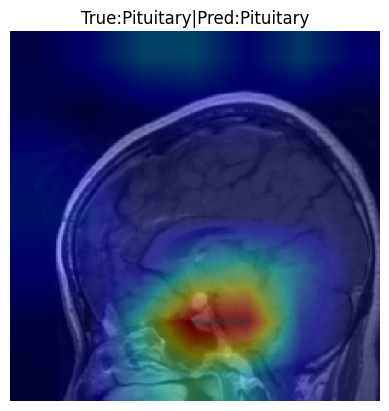

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


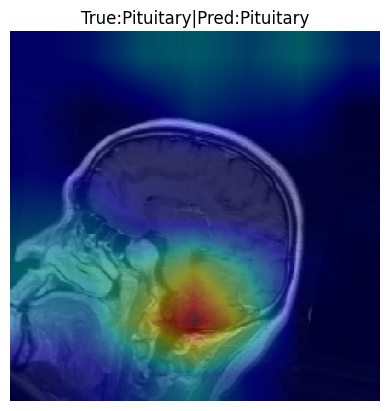

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


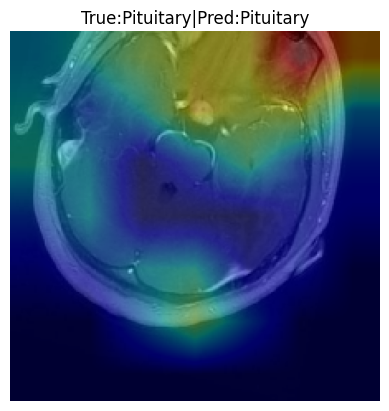

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


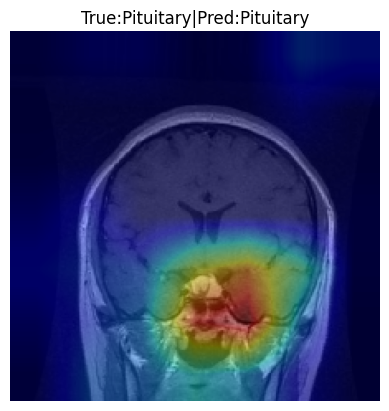

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


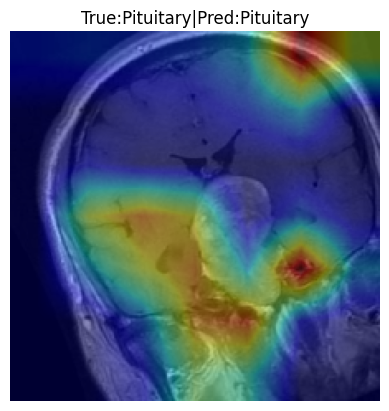

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


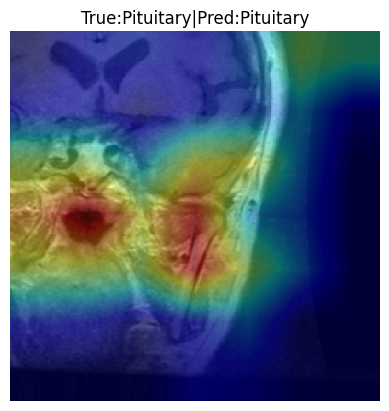

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


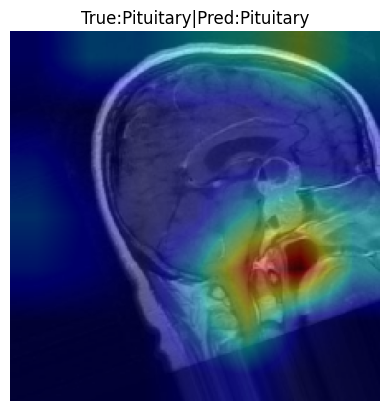

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


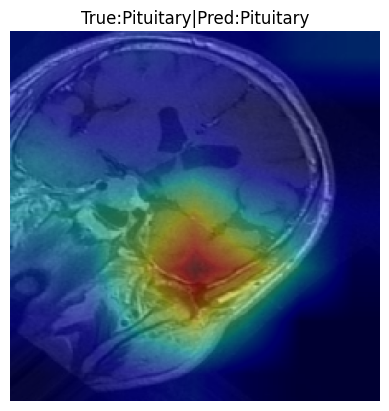

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


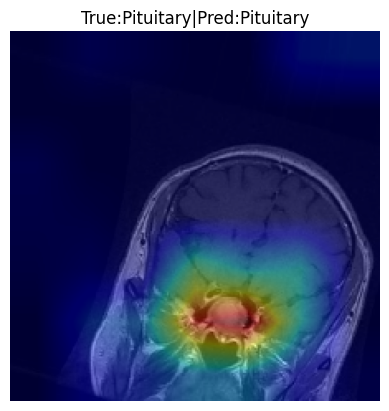

In [ ]:
#=======================================
# Grad CAM visualization
#=======================================

for i in range(1,10):
  img_path=df['path'].iloc[i]

  img=tf.keras.preprocessing.image.load_img(img_path,target_size=(224,224))

  img_array=tf.keras.preprocessing.image.img_to_array(img)/255
  img_array=np.expand_dims(img_array,0)
  # True label for dataFrame

  true_label=df['label'].iloc[i]
  preds=model.predict(img_array)
  pred_idx=np.argmax(preds)
  pred_label=class_label[pred_idx]

  heat=gradcam(model,img_array,layer_name='conv5_block3_out')

  plt.imshow(img)
  plt.imshow(heat,cmap='jet',alpha=0.4)
  plt.axis('off')
  plt.title(f'True:{true_label}|Pred:{pred_label}')
  plt.show()